# Assignment 3 - Diffusion Models

Sometimes it is helpful to consider the simplest possible version of something to better understand how it works. In the first half of the assignment we will implement a 'toy' diffusion model to learn how the different pieces of diffusion work. In the second half of the assignment, we will see the more complex implementation with DDPM (Denoising Diffusion Probablistic Models). 

## 1. Simple Diffusion Model
- The corruption process (adding noise to data)
- What a UNet is, and how to implement an extremely minimal one from scratch
- Diffusion model training
- Sampling to generate images

In [1]:
#Install the diffusers package from hugginface (need this for part 2)
%pip install -q diffusers
!pip show diffusers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
factscore 0.2.0 requires openai<0.28.0,>=0.27.7, but you have openai 0.28.0 which is incompatible.
factscore 0.2.0 requires torch<2.0.0,>=1.13.0, but you have torch 2.2.2+cu121 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Name: diffusers
Version: 0.31.0
Summary: State-of-the-art diffusion in PyTorch and JAX.
Home-page: https://github.com/huggingface/diffusers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/diffusers/graphs/contributors)
Author-email: diffusers@huggingface.co
License: Apache 2.0 License
Location: /home/asaha8/asahaenv/lib/python3.10/site-packages
Requires: filelock, huggingface-hub, importlib-metadata, numpy, Pillow, regex, requests, safetensors
Required-by: 


In [3]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import numpy as np
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchinfo import summary
from matplotlib.colors import Normalize
%matplotlib inline

#for nvidia 
has_gpu = torch.cuda.is_available()
#for mac
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print("CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("mps (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Using device {device}")

CUDA GPU is available
mps (Apple Metal) is NOT AVAILABLE
Using device cuda


### The Data
We will implement Diffusion using the MNIST dataset

In [4]:
#Load dataset and set up Data Loader 
tform = transforms.Compose([

    transforms.Resize((32, 32)), #Resize images to 32 x 32
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )) # Normalize the pixel values to between [-1, +1]

])
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=tform)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

norm = Normalize(vmin=-1, vmax=1) # This is a scaling range we will use for displaying images using imshow()

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 35597197.52it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 2171279.69it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 16485955.72it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 5849103.09it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



Input shape: torch.Size([8, 1, 32, 32])
Labels: tensor([5, 0, 4, 1, 9, 2, 1, 3])
Images range from -1.0 to 1.0


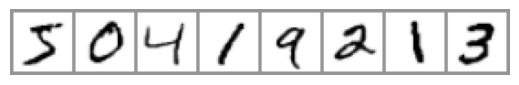

In [5]:
# Display a few images from the dataset
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
print(f"Images range from {torch.min(x)} to {torch.max(x)}")

fig = plt.figure(figsize=(5,10))
ax = fig.add_axes([0, 0, 1, 1])  # span the whole figure
ax.set_axis_off()
ax.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys', norm=norm)
plt.show()

Each image is a greyscale 32px by 32px drawing of a digit, with values ranging from -1 to 1.

### The Forward Diffusion Process 20 pts

We will define a function $\texttt{add\_noise(.)}$ to take a sequence of input images $x$ and return a noisy version of $x$. 
$x$ is a tensor of shape $[T,1,32,32]$, where $T$ is number of images, $1$ is number of channels (gray scale) and $32 \times 32$ are the pixel dimensions. 
We will define a noise schedule $\{\beta_t\}_{t=1}^T$ where $T$ is the number of images in $x$. For e.g., if there are 10 images in $x$, then create a linear spacing of 10 values between $[0,1]$, i.e., $\texttt{beta = torch.linspace(0,1,T)}$. Using $\beta_t$ create $\bar{\alpha}_t$. 
Then, estimate noisy images $x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{(1-\bar{\alpha}_t)}\epsilon$. 
The first image is noised using $\bar{\alpha}_1$, the second image is noised using $\bar{\alpha}_2$, and so on, and the $T$-th (last) image is noised using $\bar{\alpha}_T$. The function returns $\texttt{noisy\_x}$ which has the same dimensions as $x$

In [6]:
def add_noise(x):
    """Corrupt the input `x` by mixing it with noise."""
    T = x.shape[0]  # Number of images in x
    beta = torch.linspace(0, 1, T, device=x.device)  # Linear noise schedule between 0 and 1
    alpha = 1 - beta  # Calculate alpha_t
    alpha_bar = torch.cumprod(alpha, dim=0)  # Calculate cumulative product of alphas for each timestep

    # Reshape alpha_bar to match dimensions of x
    alpha_bar = alpha_bar.view(-1, 1, 1, 1)

    # Generate random noise epsilon
    epsilon = torch.randn_like(x)

    # Apply the forward diffusion process to each image
    noisy_x = torch.sqrt(alpha_bar) * x + torch.sqrt(1 - alpha_bar) * epsilon
    
    return noisy_x

Display the results to see that it works as expected:

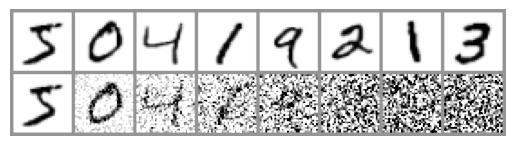

In [7]:
# Adding noise
noisy_x = add_noise(x)
all_im = torch.cat((x, noisy_x),dim=0)

plt.imshow(torchvision.utils.make_grid(all_im)[0], cmap='Greys',norm=norm)
plt.axis('off')
plt.show()

### The Simple Diffusion Neural Network 20 pts

We want to design a neural network that can take in noisy images and produce a prediction of the denoised image of the same size. A popular choice for this task is a UNet architecture. Originally designed for segmenting medical images, a UNet consists of a 'downsampling path' to compress the data and an 'upsampling path' to bring it back to its original size, similar to an autoencoder. It also includes skip connections between the downsampling and upsampling layers. Original UNet has numerous complex layers. For simplicity, we will construct a small UNet here. You can find the details of UNet here [https://nn.labml.ai/diffusion/ddpm/unet.html

We will implement a Simple UNet that takes a noised image $x_t$ and outputs $\hat{x}_0$. This is the models prediction for the first image $x_0$. The input and the output dimensions of the network are the same, $x=[B\times 1 \times 32 \times 32]$. 
We reduce the image dimensions and increase number of channels as we go down the UNet (downsampling) and arrive at the bottle-neck layer. Then we increase the image dimensions and reduce the channels as we come up the UNet (upsampling). 

Going down the UNet we have 4 layers which successively reduce image dimensions, \
$\texttt{MaxPool(SiLU(Conv(}[B\times 1 \times 32 \times 32]\texttt{)))} \rightarrow [B\times 32 \times 16 \times 16] $\
$\texttt{MaxPool(SiLU(Conv(}[B\times 32 \times 16 \times 16]\texttt{)))} \rightarrow [B\times 64 \times 8 \times 8] $\
$\texttt{MaxPool(SiLU(Conv(}[B\times 64 \times 8 \times 8]\texttt{)))} \rightarrow [B\times 128 \times 4 \times 4] $\
$\texttt{MaxPool(SiLU(Conv(}[B\times 128 \times 4 \times 4]\texttt{)))} \rightarrow [B\times 256 \times 2 \times 2] $\
We will use same convolutions with filter size $3$ and padding $1$. Use SiLU activation followed by MaxPool to reduce the image dimensions. During forward prop, we will save the outputs after the MaxPool for each of these 4 layers and use them for skip connections when we go up the UNet. 

At the bottleneck layer we will implement a same $3\times3$ convolution with SiLU activation\
$\texttt{SiLU(Conv(}[B\times 256 \times 2 \times 2]\texttt{))} \rightarrow [B\times 256 \times 2 \times 2]$

Going up the UNet we begin with $[B\times 256 \times 2 \times 2]$ from the output of the bottleneck layer. We concatenate the output of the last (4-th) down layer ($[B\times 256 \times 2 \times 2]$) to get $[B\times 512 \times 2 \times 2]$. This is the skip connection. We then upsample (nn.upSample) to get $[B\times 256 \times 4 \times 4]$. This is followed by Conv and SiLU to yield $[B\times 128 \times 4 \times 4]$\
$\texttt{SiLU(Conv(upsample(torch.cat((}[B\times 256 \times 2 \times 2],[B\times 256 \times 2 \times 2]\texttt{)))))} \rightarrow [B\times 128 \times 4 \times 4] $\
$\texttt{SiLU(Conv(upsample(torch.cat((}[B\times 128 \times 4 \times 4],[B\times 128 \times 4 \times 4]\texttt{)))))} \rightarrow [B\times 64 \times 8 \times 8] $\
$\texttt{SiLU(Conv(upsample(torch.cat((}[B\times 64 \times 8 \times 8],[B\times 64 \times 8 \times 8]\texttt{)))))} \rightarrow [B\times 32 \times 16 \times 16] $\
$\texttt{SiLU(Conv(upsample(torch.cat((}[B\times 32 \times 16 \times 16],[B\times 32 \times 16 \times 16]\texttt{)))))} \rightarrow [B\times 32 \times 32 \times 32]$

At the output we will implement a same $3\times3$ convolution with Tanh activation\
$\texttt{Tanh(Conv(}[B\times 32 \times 32 \times 32]\texttt{))} \rightarrow [B\times 1 \times 32 \times 32]$

![SimpleUnet Architecture](SimpleUnet.png)

In [8]:
class SimpleUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super(SimpleUNet, self).__init__()

        # Downsampling layers
        self.down1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.MaxPool2d(2)
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.MaxPool2d(2)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.MaxPool2d(2)
        )
        self.down4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.MaxPool2d(2)
        )

        # Bottleneck layer
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.SiLU()
        )

        # Upsampling layers
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.SiLU()
        )
        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(256, 64, kernel_size=3, padding=1),
            nn.SiLU()
        )
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.SiLU()
        )
        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.SiLU()
        )

        # Final output layer
        self.output = nn.Sequential(
            nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Downsampling path
        x1 = self.down1(x)  # [B, 32, 16, 16]
        x2 = self.down2(x1) # [B, 64, 8, 8]
        x3 = self.down3(x2) # [B, 128, 4, 4]
        x4 = self.down4(x3) # [B, 256, 2, 2]

        # Bottleneck
        x5 = self.bottleneck(x4) # [B, 256, 2, 2]

        # Upsampling path with skip connections
        x6 = self.up1(torch.cat([x5, x4], dim=1)) # [B, 128, 4, 4]
        x7 = self.up2(torch.cat([x6, x3], dim=1)) # [B, 64, 8, 8]
        x8 = self.up3(torch.cat([x7, x2], dim=1)) # [B, 32, 16, 16]
        x9 = self.up4(torch.cat([x8, x1], dim=1)) # [B, 32, 32, 32]

        # Output layer
        output = self.output(x9) # [B, 1, 32, 32]

        return output

In [9]:
# Print model architecture
m = SimpleUNet()
print(m)

# Display the number of parameters in the model
print(f"Total parameters in the model: {sum([p.numel() for p in m.parameters()])}")

# torchinfo summary may not work sometimes when there is channel concatenation
# you can comment the below line in such cases

#summary(m, input_size=(1,32,32))

SimpleUNet(
  (down1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SiLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SiLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SiLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SiLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bottleneck): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SiLU()
  )
  (up1): Sequential(
    (0): Upsample(scale_factor=2

### Training the Network 10 pts

Complete the below code to implement the Training of the UNet

Finished epoch 0. Average loss for this epoch: 0.16212
Finished epoch 1. Average loss for this epoch: 0.15381
Finished epoch 2. Average loss for this epoch: 0.15291
Finished epoch 3. Average loss for this epoch: 0.15241
Finished epoch 4. Average loss for this epoch: 0.15170
Finished epoch 5. Average loss for this epoch: 0.15154
Finished epoch 6. Average loss for this epoch: 0.15114
Finished epoch 7. Average loss for this epoch: 0.15099
Finished epoch 8. Average loss for this epoch: 0.15111
Finished epoch 9. Average loss for this epoch: 0.15088


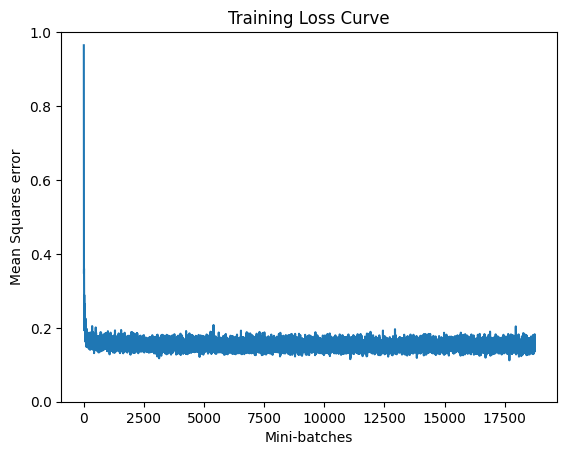

In [10]:
# Dataloader (you can mess with batch size)
batch_size = 32
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10 

# Create the network
model = SimpleUNet()
model.to(device)

# Our loss function
loss_fn = nn.MSELoss()
lr = 0.001
# The optimizer
opt = torch.optim.Adam(model.parameters(), lr=lr)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, _ in train_dataloader:  # We don't use `y` for denoising diffusion
        x = x.to(device)

        # Create noisy_x from x using add_noise()
        noisy_x = add_noise(x)
        
        # Get model prediction using noisy_x as input
        predicted_x0 = model(noisy_x)

        # Calculate loss (MSE between predicted_x0 and original x)
        loss = loss_fn(predicted_x0, x)

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:.5f}')


# View the loss curve
plt.plot(losses)
plt.ylim(0, 1)
plt.title("Training Loss Curve")
plt.xlabel('Mini-batches')
plt.ylabel('Mean Squares error')
plt.show()

We will see what the model predictions look like by getting a batch of data, corrupting by adding noise and then seeing the model's predictions:

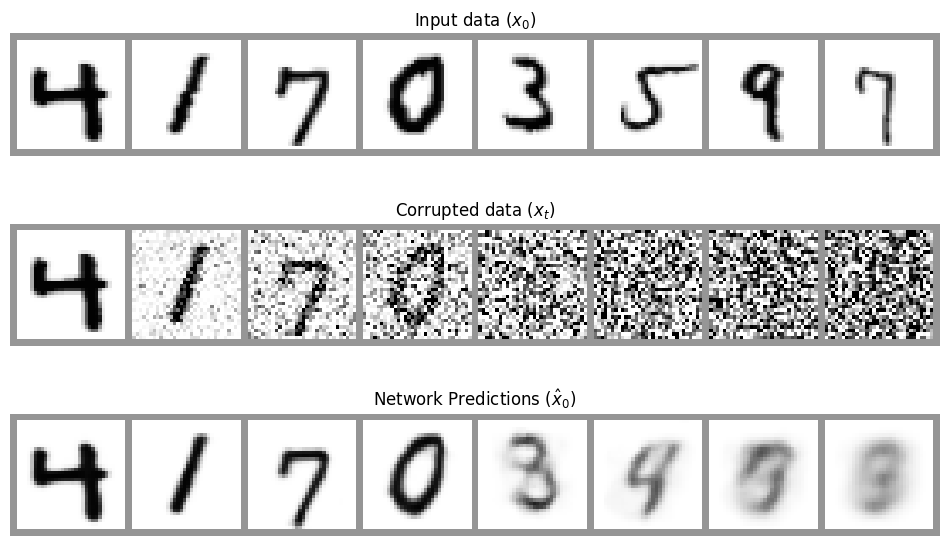

In [11]:
#@markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

noised_x = add_noise(x)

# Get the model predictions
with torch.no_grad():
  preds = model(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data ($x_0$)')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys',norm=norm)
axs[0].set_axis_off()
axs[1].set_title('Corrupted data ($x_t$)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys',norm=norm)
axs[1].set_axis_off()
axs[2].set_title('Network Predictions ($\hat{x}_0$)')
axs[2].imshow(torchvision.utils.make_grid(preds)[0], cmap='Greys',norm=norm);
axs[2].set_axis_off()

You can see that for the lower values of noise ($x_t$ for small $t$) the predictions of the original image are pretty good! But as the noise gets high ($x_t$ for large $t$) there is less for the model to work with, and by the time we get to $x_T$ the output is merely an average of the dataset with the model attempting to guess the original image. 

### Sampling

Sampling is how we generate images starting with pure noise. Our network has been trained to take noisy image $x_t$ as input and predict the original image $hat{x}_0$. Using $hat{x}_0$ we can predict the less noisy version $x_{t-1}$ using $x_{t-1} = \sqrt{\bar{\alpha}_{t-1}}x_0 + \sqrt{(1-\bar{\alpha}_{t-1})}\epsilon$. Then using $x_{t-1}$ as input to the network, we predict $\hat{x}_0$. We repeat this process until we arrive at $x_0$ 

![Training and Sampling](DDPMSampling.png)

This process is illustrated below in 10 steps, showing the Reverse Diffusion (left) and the predicted denoised images (right) at each stage. It's important to note that even though the model predicts the denoised image as early as step 1, we only move a fraction of the way there. Over a few steps, the structures start to appear and are refined until we get our final outputs.

abar =  tensor([1.0000e+00, 8.8889e-01, 6.9136e-01, 4.6091e-01, 2.5606e-01, 1.1380e-01,
        3.7935e-02, 8.4299e-03, 9.3666e-04, 0.0000e+00])


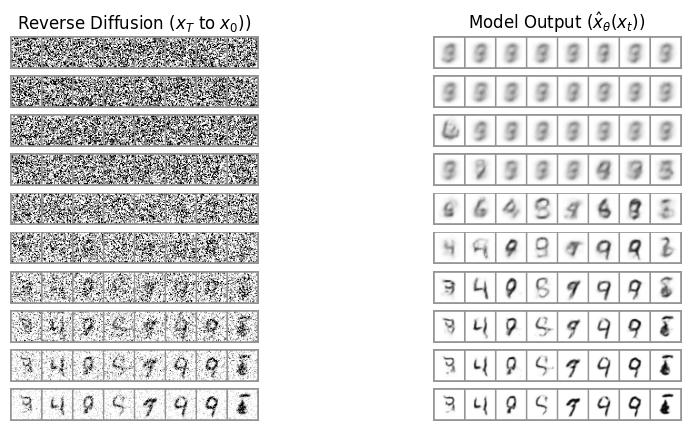

In [12]:
#@markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 10
b = torch.linspace(0, 1, n_steps) # Left to right -> more corruption
a = 1-b
abar = torch.cumprod(a, dim=0)
print("abar = ", abar)
abar = abar.view(-1, 1, 1, 1).to(device) # Sort shape so broadcasting works

x = torch.randn(8, 1, 32,32).to(device) # Start from random(pure Noise)
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = model(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    epsilon = torch.randn_like(pred).to(device)
    x = pred*torch.sqrt(abar[-i-1]) + torch.sqrt(1-abar[-i-1])*epsilon
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(10, 5), sharex=True)
axs[0,0].set_title('Reverse Diffusion ($x_T$ to $x_0$))')

axs[0,1].set_title('Model Output ($\hat{x}_{\\theta}(x_t)$)')
axs[0,1].set_axis_off()

for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0],cmap='Greys',norm=norm )
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0],cmap='Greys',norm=norm )
    axs[i,0].set_axis_off()
    axs[i,1].set_axis_off()

### Image Generation 10 pts
In the below code you will Increase the number of denoising steps and sample 64 images and display them in a grid

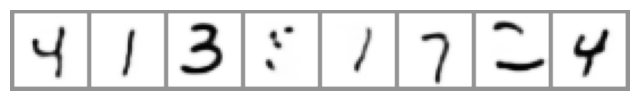

In [13]:
# Number of steps for reverse diffusion
n_steps = 100
b = torch.linspace(0, 1, n_steps)  # Left to right -> more corruption
a = 1 - b
abar = torch.cumprod(a, dim=0)  # Cumulative product for alpha_bar
abar = abar.view(-1, 1, 1, 1).to(device)  # Shape to match the broadcast dimensions

# Start from random noise
x = torch.randn(8, 1, 32, 32).to(device)  # Pure noise input
step_history = [x.detach().cpu()]  # To record each step

for i in range(n_steps):
    with torch.no_grad():  # No gradients needed during inference
        pred = model(x)  # Predict the denoised x0
    epsilon = torch.randn_like(pred).to(device)  # Sample noise for current step

    # Compute the next step x_{t-1} using predicted x0 and noise
    x = pred * torch.sqrt(abar[-i-1]) + torch.sqrt(1 - abar[-i-1]) * epsilon
    step_history.append(x.detach().cpu())  # Store each step for visualization

# Visualize the final result
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0], cmap='Greys')
ax.set_axis_off()
plt.show()


This completes the 1st half of the assignment. Now we will implement the DDPM model using the diffusers package from huggingface 

## 2. DDPM Diffusion Model

In the 2nd half we'll take a look at the implementation which is along the lines of the DDPM paper.

We'll see that
*   The diffusers `UNet2DModel` is a bit more advanced than our SimpleUNet
*   The training objective is different, involving predicting the noise rather than the denoised image
*   The model is conditioned on the amount of noise present via timestep conditioning, where $t$ is passed as an additional argument to the forward method.
*   There are a number of different sampling strategies available, which should work better than our simplistic version above.

Implementing a DDPM model is straightforward. We define a model that takes
two inputs: Images and the randomly sampled time steps. At each training step, we
perform the following operations to train our model:

1. Sample random noise from a Gaussian distribution to be added to the inputs.
2. Apply the forward process to diffuse the inputs with the sampled noise.
3. Your model takes these noisy samples as inputs and predicts the noise 
that was added
4. Given true noise and predicted noise, we calculate the error in prediction
5. We then calculate the gradients using the error and update the model weights.

Given that our model knows how to denoise a noisy sample at a given time step,
we can leverage this idea to generate new samples, starting from a pure noise
distribution.

### The UNet

The diffusers UNet2DModel model has a number of improvements over our SimpleUNet above:

*   GroupNorm applies group normalization to the inputs of each block
*   Dropout layers for smoother training
*   Multiple resnet layers per block (if layers_per_block isn't set to 1)
*   Attention (usually used only at lower resolution blocks)
*   Conditioning on the timestep.
*   Downsampling and upsampling blocks with learnable parameters

Let's create and inspect a UNet2DModel:



In [14]:
from diffusers import DDPMScheduler, UNet2DModel

2024-11-06 20:09:10.155755: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 20:09:10.168319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 20:09:10.183836: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 20:09:10.188383: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 20:09:10.200217: I tensorflow/core/platform/cpu_feature_guar

In [15]:
# Create the network 
model = UNet2DModel(
    sample_size=32,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64,64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D"   # a regular ResNet upsampling block
      ),
)

In [16]:
# Display the number of parameters in the model
print(f"Total parameters in the model: {sum([p.numel() for p in model.parameters()])}")

Total parameters in the model: 1707009


### Training Objective

In the previous (1st half) example, our model attempted to predict the denoised image. However, in DDPM and many other diffusion model implementations, the model predicts the noise used in the corruption process. For more details, please refer to the [DDPM Notebook](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/generative/ipynb/ddpm.ipynb).

### Timestep Conditioning

The UNet2DModel takes in both $x_t$ and timestep $t$. The latter is turned into an embedding and fed into the model in a number of places.
The idea is that by giving the model information about what the noise level is, it can better perform its task. While it is possible to train a model without this timestep conditioning, it does seem to help performance in some cases and most implementations include it, at least in the current literature.

 DDPM version adds noise drawn from a Gaussian distribution ($\mu=0$, $\sigma^2=1$ using torch.randn). The start and end values of $\beta$ are $1E-4$ and $0.02$. But, using $1000$ time steps we can get $\bar{\alpha}_t$ to between (0,1). 

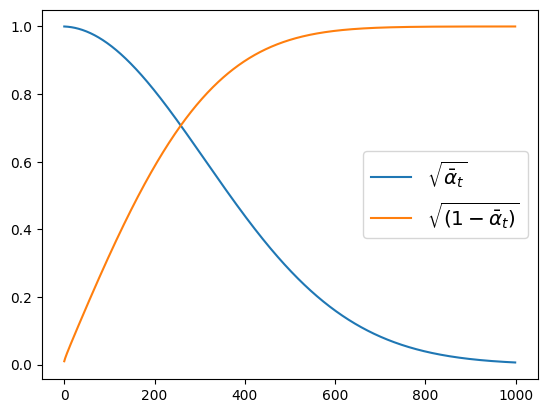

In [17]:
#initialize the noise_scheduler to 1000 timesteps and plot abar 
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

We will visualize the orginal $x$, the noisy_x using DDPM noise schedule, and the noisy_x using our linear noise schedule.

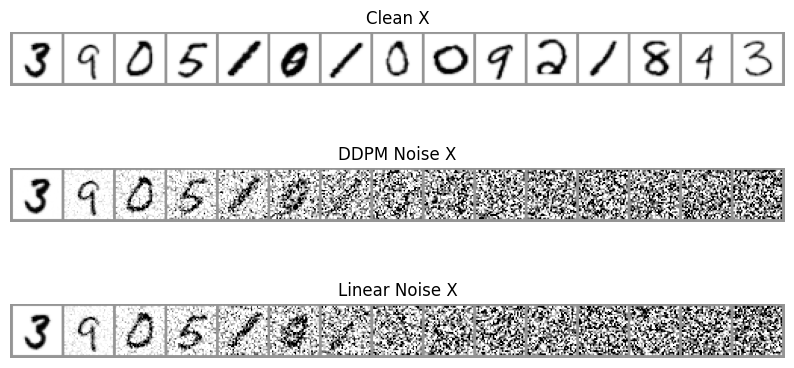

In [18]:
#@markdown visualize the DDPM noising process for different timesteps:

# Noise a batch of images to view the effect
n_steps = 15
xb, yb = next(iter(train_dataloader))
xb = xb[:n_steps]

# Add DDPM noise with scheduler
timesteps = torch.linspace(0, 999, n_steps).long().to(device)
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)

# Add our noise 
our_noise = add_noise(xb)

fig, axs = plt.subplots(3, 1, figsize=(10, 5))
# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb, nrow=n_steps)[0].detach().cpu(), norm=norm, cmap='Greys')
axs[0].set_title('Clean X')
axs[0].set_axis_off()

# Show DDPM noisy version
axs[1].imshow(torchvision.utils.make_grid(noisy_xb, nrow=n_steps)[0].detach().cpu(), norm=norm, cmap='Greys')
axs[1].set_title('DDPM Noise X');
axs[1].set_axis_off()

# Show Our noisy version
axs[2].imshow(torchvision.utils.make_grid(our_noise, nrow=n_steps)[0].detach().cpu(), norm=norm, cmap='Greys')
axs[2].set_title('Linear Noise X');
axs[2].set_axis_off()

## Traning the DDPM Model 20 pts

Implement the training using the hints below:

```python
noise = torch.randn_like(x)  # creates Gaussian random noise with same size as x
noisy_x = noise_scheduler.add_noise(x, noise, timesteps) # add noise to x based on timesteps, where timesteps is an array with number of elements equal to the number of images in x and whose values are between [0,999]   
model_prediction = model(noisy_x, timesteps).sample # The noise prediction output of the model with the same size as x
loss = mse_loss(model_prediction, noise)  # The target is the noise
```

Finished epoch 0. Average loss for this epoch: 0.03846
Finished epoch 1. Average loss for this epoch: 0.02218
Finished epoch 2. Average loss for this epoch: 0.02018
Finished epoch 3. Average loss for this epoch: 0.01881
Finished epoch 4. Average loss for this epoch: 0.01795
Finished epoch 5. Average loss for this epoch: 0.01731


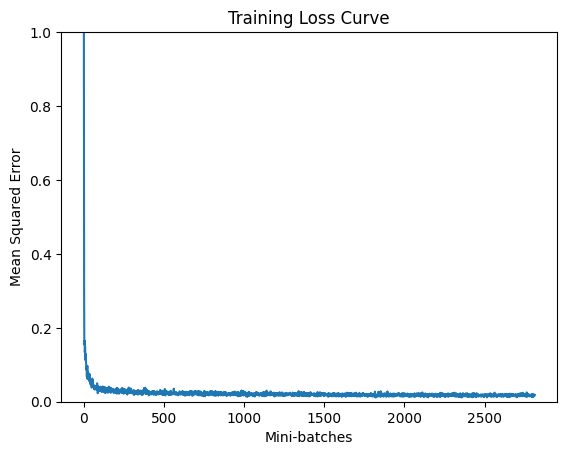

In [19]:
from torch.nn import MSELoss

# Hyperparameters
batch_size = 128
n_epochs = 6
learning_rate = 1e-3

# Create DataLoader with specified batch size
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Move model to device and set up loss function and optimizer
model.to(device)
loss_fn = MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, _ in train_dataloader:
        # Move data to the appropriate device
        x = x.to(device)
        
        # Step 1: Sample random Gaussian noise with the same size as x
        noise = torch.randn_like(x)

        # Step 2: Sample random timesteps for each image in the batch
        batch_size_actual = x.shape[0]
        timesteps = torch.randint(0, 1000, (batch_size_actual,), device=device)

        # Step 3: Use the noise scheduler to create noisy_x
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Step 4: Get model prediction (the model predicts the noise)
        model_prediction = model(noisy_x, timesteps).sample

        # Step 5: Calculate the loss (mean squared error between predicted noise and true noise)
        loss = loss_fn(model_prediction, noise)

        # Backprop and update the params:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:.5f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 1)
plt.title("Training Loss Curve")
plt.xlabel('Mini-batches')
plt.ylabel('Mean Squared Error')
plt.show()


### Sampling 20 pts
Generate 64 images and display them in a grid of 8x8 like we did in the 1st half of the assignment. 
```python
Get DDPM noise_scheduler.timesteps #these are the values of t from 999 to 0
get noise_pred = model(x,t).sample #starting with x_T get the noise prediction 
x = noise_scheduler.step(noise_pred, t, x)[0] #get x_{t-1} with noise_pred, t, and x_t as inputs
```

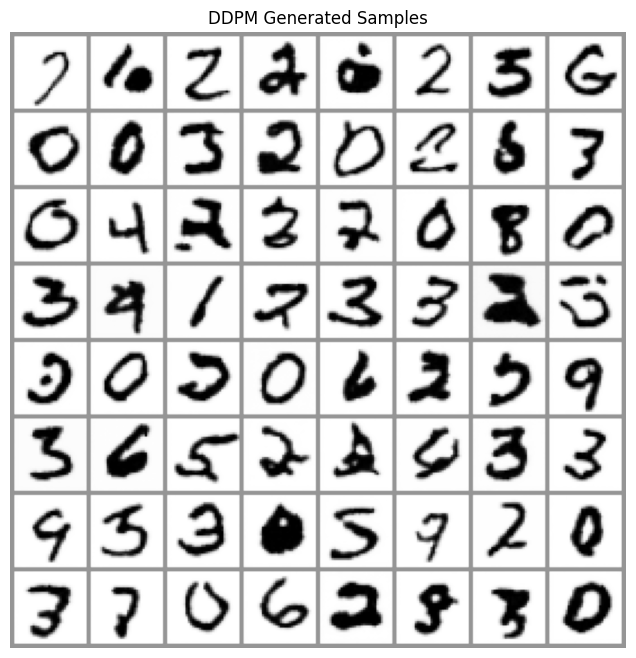

In [20]:
# Display the 64 generated images in a grid
### IMPLEMENT CODE ###


# plt.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0], cmap='Greys',norm=norm)
# plt.axis('off')
# plt.title('DDPM Generated Samples')
# plt.show()


# Number of images to generate
num_images = 64
nrow = 8  # Grid of 8x8

# Start from random noise (pure noise at the last timestep)
x = torch.randn(num_images, 1, 32, 32).to(device)

# Loop through the timesteps in reverse order (from 999 to 0)
for t in noise_scheduler.timesteps:
    with torch.no_grad():  # No need to track gradients during sampling
        # Predict the noise added at this timestep
        noise_pred = model(x, t).sample

        # Get the denoised image at the previous timestep using the noise prediction
        x = noise_scheduler.step(noise_pred, t, x)[0]

# Display the generated images in a grid
plt.figure(figsize=(8, 8))
grid = torchvision.utils.make_grid(x.detach().cpu(), nrow=nrow)
plt.imshow(grid[0], cmap='Greys', norm=norm)
plt.axis('off')
plt.title('DDPM Generated Samples')
plt.show()